## A Recommender System for Book Crossing

### Overview and definition of the problem

The goal of this project is to build a recommender system for book crossing by predicting the user’s preferences. The recommender system explores the relationships between users and items with the result of creating a top-N recommendation list for a specific user. 

There are various challenges of this kind of recommender systems listed in the following: 
- In general: Understanding the user explicitly (through ratings and explicit feedback which tends to result in sparse data) and implicitly (through user behavior)
- Cold start: New user -> Use implicit data, use cookies, geo-ip, recommend top-books or promotions, interview the user
- Cold start: New item -> Await expected interactions through search results, promotions, advertising and first bookings, use content-based attributes, random exploration
- Stoplists -> Exclude offensive books and potentially controversial topics
- Filter bubbles -> Increase diversity through books with a broader, objective appeal
- Trust -> Build trust through recognizable recommendations and transparency
- Outliers and data cleaning -> Filtering outliers out if neccessary
- Malicious user behavior (only a problem for items with a financial incentive) -> Recommendations only based on implicit ratings from purchasing or consumption data
- The effects of time -> Take recency of a rating and seasonality into account

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from math import sqrt
from lib.preprocessing import books
from lib.preprocessing import users
from lib.preprocessing import ratings
from lib.preprocessing import data_for_training as data
from lib.models import popularity_based as popularity
from lib.evaluation import recommendations as recs

Loading books, users and ratings data.

In [2]:
books = books.load_raw_df()
users = users.load_raw_df()
ratings = ratings.load_raw_df()

In [3]:
print('books:', books.shape)
print('users:', users.shape)
print('ratings:', ratings.shape)

books: (271379, 8)
users: (278858, 3)
ratings: (1149780, 3)


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Data Cleaning and Preparation

#### Cleaning the books data

- Two publisher names have been incorrectly loaded as 'Year-Of-Publication'. I will correct these data records by inserting them into the correct columns (as well as the corresponding values of the other columns).
- 'Year-Of-Publication' has values ranging from 0–2050. For all the invalid entries (0 and > 2018), I will convert these to NaNs and then replace them with mean values of remaining years. The data type will be set as int.
- Some data records (publisher and author) contain NaN. The missing publisher names will be replaced with the looked up ones; the missing author name couldn't be found out and therefore will be replaced with 'other'.

In [7]:
print(sorted(books['Year-Of-Publication'].unique()))

['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


In [8]:
books[books.isnull().any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129043,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...
209550,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220744,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221691,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


#### Cleaning the users data

- 'Age' has NaN and some very low and high values. Ages below 5 and above 90 will be replaced with NaNs and then filled with mean values of remaining ages. The data type will be set as int.

In [9]:
print(sorted(users['Age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

#### Cleaning the ratings data

- The entries in the ratings data are correct.

In [10]:
print(sorted(ratings['Book-Rating'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### Data Exploration

- Ratings data: Explicit ratings are represented by 1–10 and implicit ratings by 0. For the plot below I will use only explicit ratings and therefore split the ratings in two parts. The ratings are matched with the ISBN and User-ID from the respective tables users and books. <br> The plot shows that higher values are more common and rating 8 has been submitted most frequently. Taken from the stats, 8 is also the median rating.

In [11]:
ratings_explicit, ratings_implicit = data.separate_explicit_and_implicit_ratings()

In [95]:
print('Percentage of 0-ratings:', ratings_implicit.shape[0]/data.match_uid_and_isbn().shape[0])

Percentage of 0-ratings: 0.6277528062646981


In [13]:
ratings_explicit.describe()

,User-ID,Book-Rating
count,383852.000000,383852.000000
mean,136032.185371,7.626710
std,80482.057498,1.841331
min,8.000000,1.000000
25%,67591.000000,7.000000
50%,133790.000000,8.000000
75%,206219.000000,9.000000
max,278854.000000,10.000000


In [94]:
n_users_x_n_books = books.load_raw_df().shape[0] * users.load_raw_df().shape[0]
print('Sparsity:', 1-len(ratings_explicit)/n_users_x_n_books)

Sparsity: 0.999994927705491


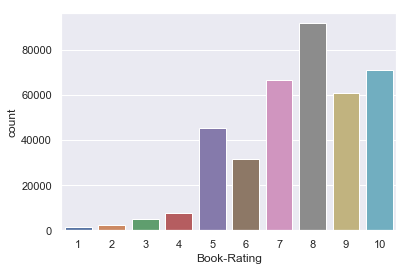

In [14]:
sns.countplot(data=ratings_explicit, x='Book-Rating');

- Ages data: The most active users are among those in their 20–30s.

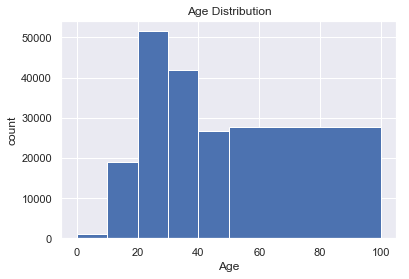

In [15]:
users['Age'].hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('count')
plt.show();

### Data Subsets and Train/Test Splits

In order to reduce computation time or to build a MVP, there are two possible approaches of generating subsets of the original data. 
- Produce a random sample with n rows or with a fraction. 
- For additionally ensuring statistical significance and simultaneously reducing dimensionality, it can be convenient to exclude users and books below some rating count threshold.
- For the train and test set split I only use the explicit ratings. It's important here to ensure that each user is represented at least once in the train and test respectively. The ratings in the test set need to be hidden when predicting and can be compared with the actual ratings afterwards.

### Popularity-based Recommendations

The simplest approach is a popularity-based recommender, meaning it is not personalized toward any user and will output the same list of recommended items. 
- Pros: Simple approach and useful for new users where there isn't any behavior data yet. 
- Cons: Not personalized
- Procedure: The top-10 list is generated by summing up the book ratings per ISBN with descending sorting. Still this approach holds the risk of recommending a book that received the most rating counts, but was not highly rated at all.

In [16]:
top10_books = popularity.build_popularity_based_recommendations()
top10_books.index = top10_books.index + 1
recs_popularity = top10_books[['Book-Title', 'Book-Author']]
recs_popularity

,Book-Title,Book-Author
1,The Lovely Bones: A Novel,Alice Sebold
2,The Da Vinci Code,Dan Brown
3,The Red Tent (Bestselling Backlist),Anita Diamant
4,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling
5,The Secret Life of Bees,Sue Monk Kidd
6,Wild Animus,Rich Shapero
7,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
8,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts
9,Girl with a Pearl Earring,Tracy Chevalier
10,Angels & Demons,Dan Brown


### Random Predictor

Before going into detail with the model-based recommenders a random predictor is presented in the following as a point of reference.

In [122]:
ratings_explicit, _ = data.separate_explicit_and_implicit_ratings()
ratings_explicit = ratings_explicit

ratings_explicit_copy = ratings_explicit.copy()
ratings_explicit_copy['Book-Rating'] = np.nan

ratings_df_random = pd.DataFrame(np.random.randint(1, 11, size=ratings_explicit.shape),
                                 index=ratings_explicit.index, columns=ratings_explicit.columns)

ratings_filled_with_random = ratings_explicit_copy.fillna(ratings_df_random)

actual_ratings = ratings_explicit['Book-Rating']
predicted_ratings = ratings_filled_with_random['Book-Rating']

RMSE = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print('RMSE for random predictions:', RMSE)

RMSE for random predictions: 4.020561543309242


### Content-based Recommendations

Content-based recommender systems include only content and attributes of each item itself. 
- Pros: Unlike collaborative filtering, if the items have sufficient descriptions, we avoid the “new item problem”. It's also more robust against popularity bias. Content information is varied and it opens up the options to use different approaches like text processing techniques, the use of semantic information and inferences (e. g. for reviews). 
- Cons: Content-based recommender systems can't capture complex user behavior and tend to over-specialization. They will recommend items similar to those already consumed, with a tendecy of creating a “filter bubble”. Sufficient meta data are required.
- Procedure: The matrix below shows the binarized genres for each ISBN which can be used to compute the cosine similarity between each item pairs. The items with the highest similarity scores (and not already read/rated by the user) are recommended. The genres which are not stored in the original data were crawled from the corresponding book database of the book crossing website. 

In [17]:
genre_matrix = data.compute_genres_matrix()
genre_matrix.head()

,ISBN,_Arts & Photography,_Audio Downloads,_Audiobooks,_Biographies & Memoirs,_Business & Investing,_Children's Books,_Computers & Internet,"_Cooking, Food & Wine",_Education,...,_Romance,_Science,_Science Fiction & Fantasy,_Sports,_Teens,_Travel,_Unknown,_Westerns,_Women's Fiction,_e-Books
0,0195153448,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0002005018,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0060973129,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0374157065,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0393045218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For users with less than two explicit ratings or only with implicit ratings it is useful to make content-based recommendations due to the lack of useful information for collaborative filtering.

In [70]:
np.random.seed(0)

# load ratings below count threshold
below_count = data.filter_ratings_below_count_threshold()
explicit_ratings_above_6 = below_count[below_count['Book-Rating'] > 6]

# create genre matrix for computing similiraty between items
genre_matrix_without_ISBN = genre_matrix.drop('ISBN', axis=1)
genre_sparse_matrix = csc_matrix(genre_matrix_without_ISBN)

for index, row in explicit_ratings_above_6.sample(n=1).iterrows():
    user_id = row['User-ID']
    isbn = row['ISBN']
    book_name = isbn_book_dict[isbn]
    print('Finding recommendations for user {0}, who has read ISBN: {1}, {2}...'.format(user_id, isbn, book_name), '\n')

    # select genre from the current book we are looking at
    book_categories = genre_matrix[genre_matrix['ISBN'] == isbn]

    # remove ISBN column and transform it into a sparse matrix
    book_categories_without_ISBN = book_categories.drop('ISBN', axis=1)
    book_categories_sparse_matrix = csc_matrix(book_categories_without_ISBN)

    # optimize performance by just computing cosine_similarity on X*Y shape (270k, 1) instead of pairwise X*X shape (270k, 270k)
    # where X contains genre information for all 270k entries
    # and Y only contains genre information for the 1 entry we need to look at
    results = cosine_similarity(X=genre_sparse_matrix, Y=book_categories_sparse_matrix)

    # transform ndarray from cosine_similarity into easy-to-access dataframe
    results_df = pd.DataFrame(results)
    results_df.set_axis([isbn], axis=1, inplace=True)
    results_df.set_axis(genre_matrix['ISBN'], inplace=True)
    topn_results = results_df.sort_values(by=isbn, ascending=False).reset_index().truncate(after=4)
    
    # making recommendations
    isbn_book_dict = recs.map_isbn_to_names()
        
    for rec_index, rec_row in topn_results.iterrows():
        rec_isbn = rec_row['ISBN']
        rec_book_name = isbn_book_dict[rec_isbn]
        print('Top {0} ISBN: {1}, {2}'.format(rec_index + 1, rec_isbn, rec_book_name))

Finding recommendations for user 93122, who has read ISBN: 0816745307, Hey, Dad, Get a Life!... 

Top 1 ISBN: 0893752835, My Secret Hiding Place
Top 2 ISBN: 0768102111, Crocodiles (Know-It-Alls (Hardcover))
Top 3 ISBN: 0307001504, The Cat That Climbed the Christmas Tree (Little Golden Book)
Top 4 ISBN: 0887434347, Good Morning, Farm (Fisher-Price a Little People Story Book)
Top 5 ISBN: 0307123200, Grover's Book of Cute Things to Touch (Golden Sturdy Shape)


The recommended books are quite similar to the book the user has read. Nevertheless the recommendations can be adjusted more when using more metadata for computing similarity depending on how individualized the results are supposed to be.

### Collaborative Filtering

Collaborative filtering models are based on the collaborative user behavior. The key idea behind this model is that similar users share the same interest and that similar items are liked by a user (user-based and item-based collaborative filtering respectively). 
- Pros: It's a simplistic and intuitive approach and easy to interpret the recommendations made by the system. Information about the items or the users themselves are not required. By using KNN it's robust to noisy data by averaging k-nearest neighbors.
- Cons: Sparsity in general can be difficult to deal with when using collaborative filtering, mainly due to the fact that collaborative systems rely on similar user rating on one item for prediction. If one item is not rated by enough users, collaborative system results can be very much biased. Because of the large similarity matrices it can be computationally expensive. Therefore the matrices can't be computed and updated regularly which leads to the cold start problem. 
- Procedure: Either an user-based or item-based collaborative filtering can be used. In most cases the item-based method is more stable with changes in the ratings matrix (in comparison to the users' interests which can change fast) and it often has much fewer dimensions than the user-based approach (in this case the dimensions are almost equal). Dependent on the approach the necessary rating matrix is UxI (shown below) or IxU. The following examples show how user-based recommendations would be generated. As the data are very sparse and this method is very computational expensive, I decided to densify the ratings data by defining a threshold for both users and books ratings count.

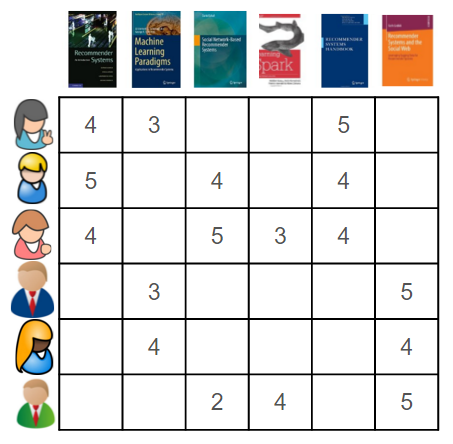

In [66]:
Image('lib/data/images/user-preferences.png', width=400)
# Source: https://buildingrecommenders.wordpress.com/2015/11/18/overview-of-recommender-algorithms-part-2/

The user-based collaborative filtering compares the preferences of each user to every other user.

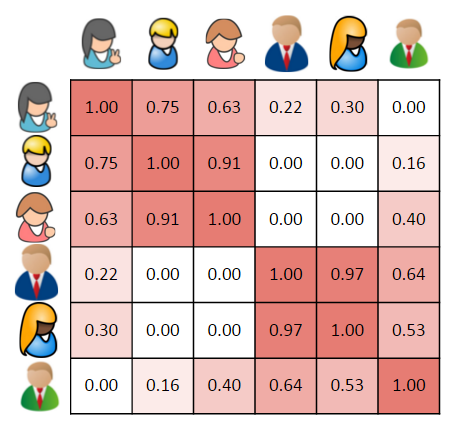

In [67]:
Image('lib/data/images/user-based-similarity-full.png', width=400)
# Source: https://buildingrecommenders.wordpress.com/2015/11/18/overview-of-recommender-algorithms-part-2/

The recommendations are generated based on the most similar users' preferences (user-based) or the items most similar to the ones the user likes (item-based) measured by cosine similarity and predicted with weighted average ratings.

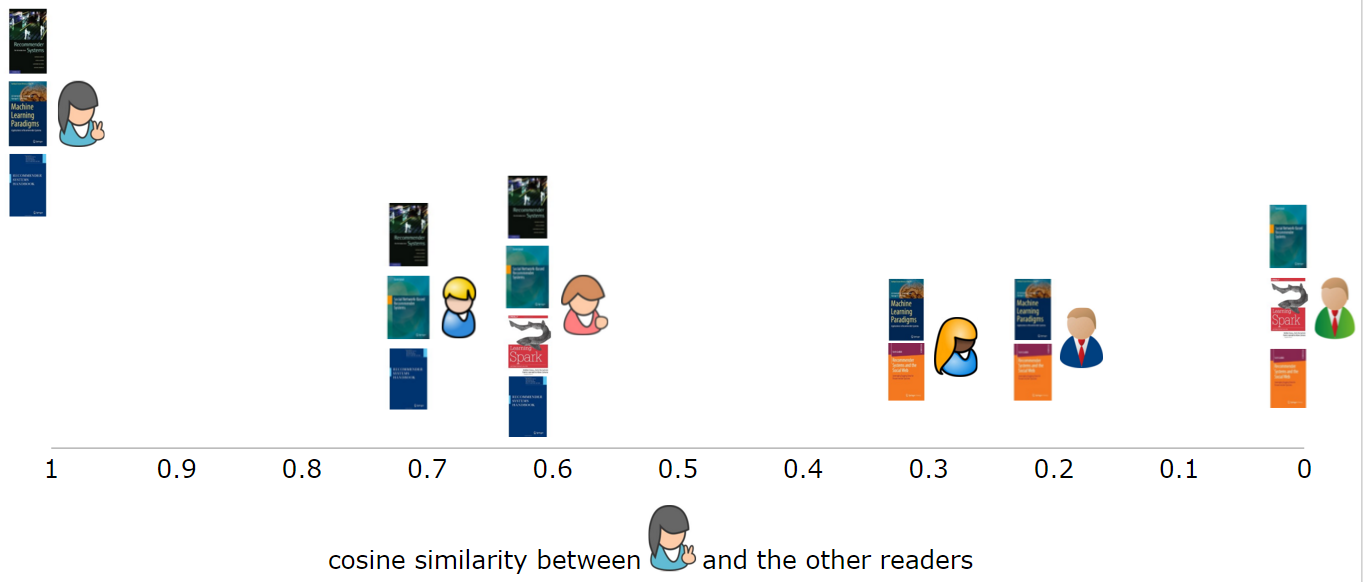

In [68]:
Image('lib/data/images/user-based-similarity-single-user.png', width=1000)
# Source: https://buildingrecommenders.wordpress.com/2015/11/18/overview-of-recommender-algorithms-part-2/

In [99]:
np.random.seed(0)

# load ratings above count threshold
ratings_above_count_threshold = data.densify_ratings_df(user_ratings_count_threshold=50,
                                                        isbn_ratings_count_threshold=200)

# create test set and copy of original ratings
train_set, test_set = train_test_split(ratings_above_count_threshold, test_size=0.1)
ratings_copy = train_set.copy()

# compute cosine similarity between each user and every other user who rated the book we are looking at
user_series = pd.Series(ratings_above_count_threshold['User-ID'].unique())

for user_index, user_id in user_series.iteritems():
    print("Processing user:", user_id)
    isbn_df = pd.DataFrame(ratings_above_count_threshold['ISBN']).drop_duplicates()
    ratings_by_user = pd.DataFrame(ratings_above_count_threshold[ratings_above_count_threshold['User-ID'] == user_id])
    isbn_from_test_set = pd.DataFrame(test_set[test_set['User-ID'] == user_id]['ISBN'])
    isbn_not_rated_by_user = isbn_df[~isbn_df['ISBN'].isin(ratings_by_user['ISBN'])]
    isbn_not_rated_by_user = isbn_not_rated_by_user.append(isbn_from_test_set)

    for isbn_index, isbn_row in isbn_not_rated_by_user.iterrows():
        isbn_for_prediction = isbn_row['ISBN']

        users_for_knn = ratings_above_count_threshold[ratings_above_count_threshold['ISBN'] == isbn_for_prediction][
            'User-ID']
        ratings_by_other_users = ratings_above_count_threshold[ratings_above_count_threshold['User-ID'].isin(users_for_knn)]
        ratings_for_knn = pd.concat([ratings_by_user, ratings_by_other_users]).drop_duplicates()
        ratings_pivot = ratings_for_knn.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

        item_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=min(users_for_knn.count(), 20))
        item_knn.fit(ratings_pivot)
        distances, indices = item_knn.kneighbors(ratings_pivot.loc[user_id, :].values.reshape(1, -1))

        knn_ratings = ratings_pivot.iloc[indices.flatten()[1:], :]

        # making predictions
        similarities = 1 - distances
        if similarities.flatten()[1:].sum() > 0:
            predicted_rating = np.average(knn_ratings[isbn_for_prediction], weights=similarities.flatten()[1:])
        else:
            predicted_rating = knn_ratings[isbn_for_prediction].mean()

        predicted_ratings = pd.DataFrame([[user_id, isbn_for_prediction, round(predicted_rating)]],
                                         columns=list(ratings_copy.columns))
        ratings_copy = ratings_copy.append(predicted_ratings, ignore_index=True)

# making recommendations
recs_predicted_ratings_df = ratings_copy.pivot(index='User-ID', columns='ISBN', values='Book-Rating').sample(n=1)

isbn_book_dict = recs.map_isbn_to_names()

for user_id, row in recs_predicted_ratings_df.iterrows():
    topn_results = row.sort_values(ascending=False).iloc[:5]
    print('Finding recommendations for user {0}...'.format(user_id))

    rec_index = 1
    for rec_isbn, rec_score in topn_results.iteritems():
        rec_book_name = isbn_book_dict[rec_isbn]
        print('Top {0} ISBN: {1}, {2}'.format(rec_index, rec_isbn, rec_book_name))
        rec_index += 1

# metrics
actual_ratings = []
predicted_ratings = []
for index, row in test_set.iterrows():
    actual_ratings.append(row['Book-Rating'])
    predicted_rating = ratings_copy[(ratings_copy['User-ID'] == row['User-ID']) & (ratings_copy['ISBN'] == row['ISBN'])]
    predicted_ratings.append(predicted_rating.iloc[0, 2])

RMSE_test_set = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print('RMSE test set: ', RMSE_test_set)

Processing user: 277427
Processing user: 278137
Processing user: 254
Processing user: 638
Processing user: 1424
Processing user: 1733
Processing user: 2033
Processing user: 2110
Processing user: 2766
Processing user: 2891
Processing user: 2977
Processing user: 3363
Processing user: 3827
Processing user: 4017
Processing user: 6073
Processing user: 6242
Processing user: 6251
Processing user: 6543
Processing user: 6563
Processing user: 6575
Processing user: 7125
Processing user: 7158
Processing user: 7346
Processing user: 7915
Processing user: 8066
Processing user: 8245
Processing user: 8253
Processing user: 8454
Processing user: 8681
Processing user: 9417
Processing user: 10314
Processing user: 10447
Processing user: 10560
Processing user: 11601
Processing user: 11676
Processing user: 11687
Processing user: 11993
Processing user: 12100
Processing user: 12538
Processing user: 12824
Processing user: 12982
Processing user: 13273
Processing user: 13552
Processing user: 13582
Processing user:

Processing user: 129716
Processing user: 129851
Processing user: 130571
Processing user: 130847
Processing user: 132375
Processing user: 132492
Processing user: 133296
Processing user: 133571
Processing user: 133689
Processing user: 133747
Processing user: 134434
Processing user: 134797
Processing user: 135045
Processing user: 135149
Processing user: 135265
Processing user: 135351
Processing user: 135360
Processing user: 135458
Processing user: 135609
Processing user: 136139
Processing user: 136205
Processing user: 136252
Processing user: 136382
Processing user: 136491
Processing user: 137589
Processing user: 138543
Processing user: 138578
Processing user: 138602
Processing user: 138844
Processing user: 138883
Processing user: 139828
Processing user: 139913
Processing user: 140000
Processing user: 140036
Processing user: 140358
Processing user: 141444
Processing user: 141493
Processing user: 141710
Processing user: 141819
Processing user: 141902
Processing user: 142121
Processing user:

Processing user: 250962
Processing user: 251140
Processing user: 251394
Processing user: 251422
Processing user: 251843
Processing user: 251844
Processing user: 252222
Processing user: 252820
Processing user: 252865
Processing user: 253821
Processing user: 253871
Processing user: 254377
Processing user: 254465
Processing user: 254899
Processing user: 255078
Processing user: 255092
Processing user: 255218
Processing user: 255489
Processing user: 256167
Processing user: 257028
Processing user: 257204
Processing user: 257700
Processing user: 258482
Processing user: 258534
Processing user: 258938
Processing user: 259118
Processing user: 259260
Processing user: 259629
Processing user: 260183
Processing user: 260897
Processing user: 261105
Processing user: 261603
Processing user: 261829
Processing user: 261998
Processing user: 262902
Processing user: 263163
Processing user: 264031
Processing user: 264321
Processing user: 264525
Processing user: 264657
Processing user: 265115
Processing user:

Regarding the books with the highest ratings from user 143253 the recommendations cover several genres which are read and liked the most by this user, except the genre 'children's books'. The fact that no children's book was recommended certainly arises from the age group of this user and the approach of collaborative filtering of finding similar users.

The RMSE of 1.61 was achieved with 20 k-neighbors. Few k-neighbors result in worse RMSE because the ratings are averaged over just few neighbors.

### Matrix Factorization

Matrix factorization based methods attempt to reduce dimensionality of the interaction matrix by separating a matrix into constituent parts and approximate it by two or more small matrices with k latent components. Two different methods of decomposition are used in the following: Singular value decomposition and non-negative matrix factorization.
- Pros: It can find underlying interactions/features between users and items by deriving tastes and preference vectors from the raw data and therefore often leads to recommendations of good quality.
- Cons: Matrix factorization systems need to be retrained when a new user or item is added. Even though the system might have gathered some interactions for that new user or provides attributes for a new item, it's latent factors are not available and therefore no recommendations can be computed.
- Procedure: The known UxI matrix is decomposed into the two corresponding product matrices. These are then multiplied with the computed sigma matrix by dot product which then represents the matrix with all the predicted ratings. In the example below the matrices U and V respectively show the k-latent features that are found by the matrix factorization.

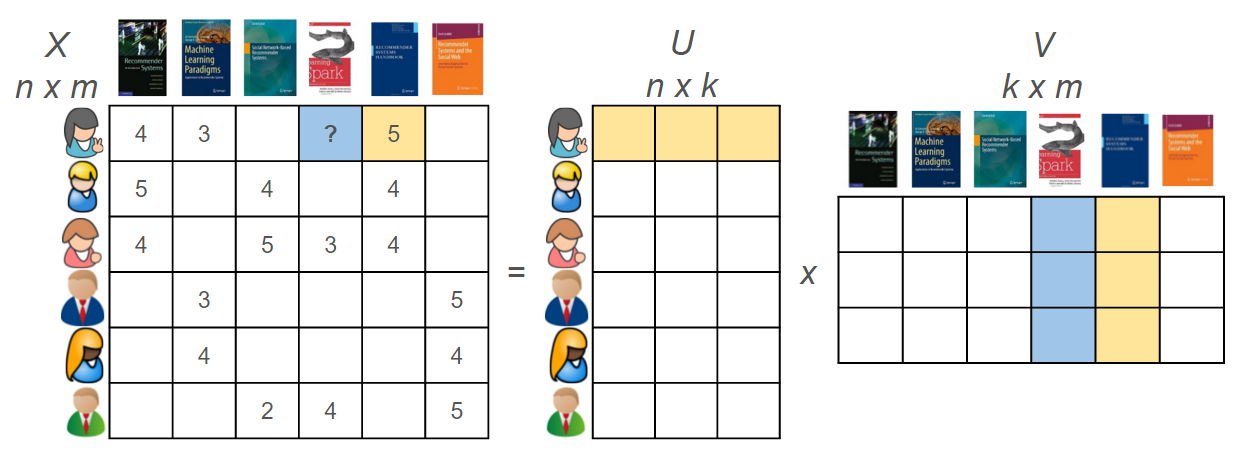

In [69]:
Image('lib/data/images/matrix-factorisation.png')
# Source: https://buildingrecommenders.wordpress.com/2015/11/18/overview-of-recommender-algorithms-part-2/

#### Singular Value Decomposition (SVD)
SVD approximates the original data matrix with three lower rank matrices by taking the dot product. SVD will give you the two matrices U and V which can be interpreted as the typical users and the typical books respectively. The third one is a diagonal matrix which represents the weights. 

In [121]:
np.random.seed(0)

# load ratings above count threshold
ratings_above_count_threshold_df = data.densify_ratings_df(user_ratings_count_threshold=50,
                                                           isbn_ratings_count_threshold=200)

# create test set and copy of original ratings
train_set, test_set = train_test_split(ratings_above_count_threshold_df, test_size=0.1)
ratings_copy = train_set.copy()

mean_rating = ratings_above_count_threshold_df['Book-Rating'].mean()

test_set_without_ratings = test_set.copy()
test_set_without_ratings['Book-Rating'] = np.nan

full_set_without_test_set_ratings = pd.concat([train_set, test_set_without_ratings])

ratings_pivot = full_set_without_test_set_ratings.pivot(index='User-ID', columns='ISBN',
                                                        values='Book-Rating').fillna(mean_rating)

# decomposition and prediction
R_pivot = ratings_pivot.values
sparse_R = csr_matrix(R_pivot, dtype=float)

U, sigma, Vt = svds(sparse_R, k=20)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(U, np.dot(sigma, Vt))

all_user_predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings)
all_user_predicted_ratings_df.set_axis(ratings_pivot.columns, axis=1, inplace=True)
all_user_predicted_ratings_df.set_axis(ratings_pivot.index, axis=0, inplace=True)

# making recommendations
recs_predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns=ratings_pivot.columns).set_index(
    ratings_pivot.index).sample(n=1)

isbn_book_dict = recs.map_isbn_to_names()

for user_id, row in recs_predicted_ratings_df.iterrows():
    topn_results = row.sort_values(ascending=False).iloc[:5]
    print('Finding recommendations for user {0}...'.format(user_id), '\n')

    rec_index = 1
    for rec_isbn, rec_score in topn_results.iteritems():
        rec_book_name = isbn_book_dict[rec_isbn]
        print('Top {0} ISBN: {1}, {2}'.format(rec_index, rec_isbn, rec_book_name))
        rec_index += 1

# metrics
actual_ratings = []
predicted_ratings = []
for index, row in test_set.iterrows():
    actual_ratings.append(row['Book-Rating'])
    predicted_ratings.append(all_user_predicted_ratings_df.at[row['User-ID'], row['ISBN']])

RMSE_train_set = sqrt(mean_squared_error(R_pivot, all_user_predicted_ratings))
print('\nRMSE train set: ', RMSE_train_set)

RMSE_test_set = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print('RMSE test set: ', RMSE_test_set)

Finding recommendations for user 143253... 

Top 1 ISBN: 0316666343, The Lovely Bones: A Novel
Top 2 ISBN: 0316601950, The Pilot's Wife : A Novel
Top 3 ISBN: 0385484518, Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson
Top 4 ISBN: 0671021001, She's Come Undone (Oprah's Book Club)
Top 5 ISBN: 0446310786, To Kill a Mockingbird

RMSE train set:  0.21504277880028702
RMSE test set:  1.7753820666054043


The recommendations are a bit more diverse which is good, but the RMSE is a bit worse in comparison to collaborative filtering with KNN.

The RMSE of 1.78 was achieved with 20 latent factors.

#### Non-negative matrix factorization (NMF)
NMF considering the non-negativity of data makes the results more interpretable than those of SVD. It finds only two factor matrices whose dot product approximates the original data matrix.

In [100]:
np.random.seed(0)

# load ratings above count threshold
ratings_above_count_threshold_df = data.densify_ratings_df(user_ratings_count_threshold=50,
                                                           isbn_ratings_count_threshold=200)

# create test set and copy of original ratings
train_set, test_set = train_test_split(ratings_above_count_threshold_df, test_size=0.1)
ratings_copy = train_set.copy()

mean_rating = ratings_above_count_threshold_df['Book-Rating'].mean()

test_set_without_ratings = test_set.copy()
test_set_without_ratings['Book-Rating'] = np.nan

full_set_without_test_set_ratings = pd.concat([train_set, test_set_without_ratings])

ratings_pivot = full_set_without_test_set_ratings.pivot(index='User-ID', columns='ISBN',
                                                        values='Book-Rating').fillna(mean_rating)

# decomposition and prediction
R_pivot = ratings_pivot.values

model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(R_pivot)
H = model.components_
all_user_predicted_ratings = np.dot(W, H)

all_user_predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings)
all_user_predicted_ratings_df.set_axis(ratings_pivot.columns, axis=1, inplace=True)
all_user_predicted_ratings_df.set_axis(ratings_pivot.index, axis=0, inplace=True)

# making recommendations
recs_predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns=ratings_pivot.columns).set_index(
    ratings_pivot.index).sample(n=1)

isbn_book_dict = recs.map_isbn_to_names()

for user_id, row in recs_predicted_ratings_df.iterrows():
    topn_results = row.sort_values(ascending=False).iloc[:5]
    print('Finding recommendations for user {0}...'.format(user_id), '\n')

    rec_index = 1
    for rec_isbn, rec_score in topn_results.iteritems():
        rec_book_name = isbn_book_dict[rec_isbn]
        print('Top {0} ISBN: {1}, {2}'.format(rec_index, rec_isbn, rec_book_name))
        rec_index += 1

# metrics
actual_ratings = []
predicted_ratings = []
for index, row in test_set.iterrows():
    actual_ratings.append(row['Book-Rating'])
    predicted_ratings.append(all_user_predicted_ratings_df.at[row['User-ID'], row['ISBN']])

RMSE_train_set = sqrt(mean_squared_error(R_pivot, all_user_predicted_ratings))
print('\nRMSE train set: ', RMSE_train_set)

RMSE_test_set = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print('RMSE test set: ', RMSE_test_set)

Finding recommendations for user 143253... 

Top 1 ISBN: 0316666343, The Lovely Bones: A Novel
Top 2 ISBN: 0156027321, Life of Pi
Top 3 ISBN: 0385484518, Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson
Top 4 ISBN: 0345370775, Jurassic Park
Top 5 ISBN: 0375727345, House of Sand and Fog

RMSE train set:  0.2347238655072349
RMSE test set:  1.7757398944154021


The RMSE of 1.78 is almost the same, however the recommendations are a bit different than with SVD.

### Neural Network

A neural network based recommender system can enable the possibility to find complex relationships between several features and to use implicit feedback as input data. It simulates a human's brain and consists of several layers and nodes which are each connected. 
- Pros: Neural networks have a big potential to outperform most machine learning algorithms especially if there is a lot of data you fed into them. They have the ability to learn and model non-linear and complex relationships. 
- Cons: Neural networks are kind of a black box because the way of creating the output cannot be reconstructed. Besides, dependent on the complexity of the problem the development time is usually much higher and a lot of data is needed in order to train a neural network properly. They are also more computationally expensive than traditional algorithms.
- Procedure: The users and items are fed as embeddings into the neural network. Embeddings are mappings of a discrete categorical variable to a vector of continuous numbers. They are useful because they can reduce the dimensionality of categorical variables and create meaningful representations.

### Prospect

How can this recommender system be further developed?
- Use more book metadata for content-based recommendations
- Integrate demographic and location features into the neural network
- Use more evaluation metrics, for example hit rate, coverage, diversity, novelty, churn, responsiveness (as an online metric you would do a A/B test and measure the actual user behavior towards your recommendations
- Consider the challenges of recommender systems mentioned above and implement solutions if neccessary